In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import os
from matplotlib import gridspec
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
pd.options.mode.chained_assignment = None  # default='warn'


In [3]:
# Month remap by water year (starting in October)
custom_month_order = {10: 1, 11: 2, 12: 3, 1: 4, 2: 5, 3: 6, 4: 7, 5: 8, 6: 9, 7: 10, 8: 11, 9: 12}
# date range to use #
start_date = '2014-10-01'
end_date = '2019-10-01'

In [4]:
## read precipitation data ##
PPT=pd.read_csv('/path/to/directory/TWB_datasets/Tanguro_PrecipChirps.csv')
ppt=pd.DataFrame(data=PPT)
ppt['date'] = pd.to_datetime(ppt['date'], format='mixed')
ppt['water_year'] = ppt['date'].apply(lambda x: x.year if x.month < 10 else x.year + 1)
# Map the custom order to the existing 'Month' column
ppt['Custom_Month_Order'] = ppt['month'].map(custom_month_order)
ppt["Forest_Pchirp2.0_cm"] =ppt["Forest_Pchirp2.0"]/100
ppt["Agriculture_Pchirp2.0_cm"] =ppt["Agriculture_Pchirp2.0"]/100
ppt=ppt.loc[(ppt['date'] >= start_date) & (ppt['date'] <= end_date)]

In [5]:
# Function to convert decimal year to datetime
## read evapotranspiration data ##
ET=pd.read_csv('/path/to/directory/TWB_datasets/TanguroShapes_QC_MODIS061_ETmm_8days_2000_2024.csv')
et=pd.DataFrame(data=ET)
et['date'] = pd.to_datetime(et['date'])
et['month'] = et['date'].dt.month
et['year'] = et['date'].dt.year
et['water_year'] = et['date'].apply(lambda x: x.year if x.month < 10 else x.year + 1)
et['Custom_Month_Order'] = et['month'].map(custom_month_order)

/var/folders/0t/wff4mf392zbg2xjjnxlpkt3c0000gr/T/ipykernel_19508/3421237528.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  et['date'] = pd.to_datetime(et['date'])


In [6]:
# Deal with 8 day ET dataset to find average monthly ET 
# Create a DataFrame with all calendar dates for the year
full_dates = pd.date_range(start='2014-10-01', end='2019-09-30', freq='D')
full_df = pd.DataFrame({'date': full_dates})

# Divide each value by 8
et['Forest_ETmean_daily'] = et['Forest_ETmean'] / 8
et['Ag_ETmean_daily'] = et['Ag_ETmean'] / 8

# Create an empty DataFrame to store the repeated values for both columns
expanded_df = pd.DataFrame(columns=['date', 'Forest_ETmean_daily', 'Ag_ETmean_daily'])

# For each date in df, repeat the daily_value1 and daily_value2 for that date and the previous 7 days
for index, row in et.iterrows():
    for i in range(8):
        new_row = pd.DataFrame({
            'date': [row['date'] - pd.Timedelta(days=i)],
            'Forest_ETmean_daily': [row['Forest_ETmean_daily']],
            'Ag_ETmean_daily': [row['Ag_ETmean_daily']]
        })
        expanded_df = pd.concat([expanded_df, new_row], ignore_index=True)


# Merge with the full calendar dates to ensure all dates are covered
result_df = pd.merge(full_df, expanded_df, on='date', how='left')

# Fill NaN values with 0 (for dates not covered by the 8-day periods)
result_df['Ag_ETmean_daily'] = result_df['Ag_ETmean_daily'].fillna(0)
result_df['Forest_ETmean_daily'] = result_df['Forest_ETmean_daily'].fillna(0)

# Now, group by month and calculate the monthly total
result_df['month'] = result_df['date'].dt.to_period('M')

monthly_sum = result_df.groupby('month').agg({
    'Forest_ETmean_daily': 'sum',
    'Ag_ETmean_daily': 'sum'
}).reset_index()
 
#rename and add other rows
et=monthly_sum
et['water_year'] = et['month'].apply(lambda x: x.year if x.month < 10 else x.year + 1)

et['year'] = et['month'].dt.year
et['month'] = et['month'].dt.month
et['Custom_Month_Order'] = et['month'].map(custom_month_order)
et["ET_agriculture_mean"] =et["Ag_ETmean_daily"]
et["ET_forest_mean"] =et["Forest_ETmean_daily"]
et["Agriculture_Etnew_cm"] =et["Ag_ETmean_daily"]/100
et["Forest_Etnew_cm"] =et["Forest_ETmean_daily"]/100


/var/folders/0t/wff4mf392zbg2xjjnxlpkt3c0000gr/T/ipykernel_19508/3121058707.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  expanded_df = pd.concat([expanded_df, new_row], ignore_index=True)


In [7]:
## read soil moisture data ##
sm=pd.read_csv('/path/to/directory/TWB_datasets/master_TDR_vwc_cm_2023.csv')
sm=pd.DataFrame(sm)
sm.drop('Unnamed: 0', axis=1, inplace=True)
location_dict = {
    'MUT': "Agriculture","AP1":"Agriculture", "A1C":"Agriculture", "AR3":"Agriculture",
    "C02": "Forest", "K04": "Forest", "M08": "Forest", "P02": "Forest",
    "G26": "Burned", "H19": "Burned", "P25": "Burned"}

In [9]:
## read discharge data ##
# Path to the directory containing CSV files
directory_path = '/path/to/directory/TWB_datasets/CSVs'

# Create an empty lists to store the dataframes (hourly and monthly)
dfs=[]
monthly_dfs=[]
# Dictionary to map file names to locations
location_attributes = {
    'APP1': {"Type":'Mixed', "Area_m2": 14200000, "%Forest": 28.5, "%Cleared": 71.5},
    'APP2':  {"Type":'Forest', "Area_m2": 8400000, "%Forest": 100, "%Cleared": 0},
    'APP2A':  {"Type":'Forest', "Area_m2": 13700000, "%Forest": 97.3, "%Cleared": 2.7},
    'APP5':  {"Type":'Mixed', "Area_m2": 5800000, "%Forest": 29.5, "%Cleared": 70.5},
    'APPArea3':  {"Type":'Agriculture', "Area_m2": 6700000, "%Forest": 3.7, "%Cleared": 96.3},
    'Cascavel':  {"Type":'Agriculture', "Area_m2": 7700000, "%Forest": 17.5, "%Cleared": 82.5},
    'APPNascente':  {"Type":'Agriculture', "Area_m2": 4100000, "%Forest": 40.1, "%Cleared": 59.9}
}

# Iterate over files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.csv'):
        
        # Read CSV file
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(file_path)

        # extract name of watershed
        df_name = df['Watershed'][2]
        
        # Add a new column with the location based on the dictionary
        # Add new columns with attributes based on location
        for attribute, value in location_attributes[df_name].items():
            df[attribute] = value
        
        #Drop any time periods without data in them
        df = df.dropna(subset=['Date'])
        
        #Convert Flow from L/s to mm/h using watershed area called from dictionary
        df['Flow_lps'] = pd.to_numeric(df['Flow_lps'], errors='coerce')
        df['Flow m3/s']=df['Flow_lps']*.001
        df['Flow m/s']=df['Flow m3/s']/df["Area_m2"][1] #watershed area in m2
        df['Flow mm/s']=df['Flow m/s']*1000
        df['Flow mm/h']=df['Flow mm/s']*3600
        df['Date'] = pd.to_datetime(df['Date'], format="%m/%d/%y %H:%M")
        df_index=df.reset_index().copy()
        dfs.append(df_index)
        
        # Resample the data monthly and sum the values
        df.set_index('Date', inplace=True)
        cover_type=df['Type'].iloc[1]
        watershed=df['Watershed'].iloc[1]
        monthly_df = df["Flow mm/h"].resample('M').sum()
        monthly_df=monthly_df.to_frame().rename(columns={1: 'Flow mm/month'})
        
        # Add other columns to the resampled DataFrame
        monthly_df["Flow_lps"] = df["Flow_lps"].resample('M').sum()
        monthly_df['Type'] = cover_type
        monthly_df['Watershed'] = watershed
        monthly_df.index=pd.to_datetime(monthly_df.index)
        monthly_df['date'] = monthly_df.index.to_period('M')
        monthly_df['water_year'] = monthly_df['date'].apply(lambda x: x.year if x.month < 10 else x.year + 1)
        monthly_df['Month'] = monthly_df['date'].dt.month
        monthly_df['Custom_Month_Order'] = monthly_df['Month'].map(custom_month_order)
        monthly_df=monthly_df.reset_index()
        # Drop the first and last months that are not complete months of data
        monthly_dfs.append(monthly_df[1:-1]) 

# Concatenate all DataFrames into a single DataFrame
concatenated_df = pd.concat(dfs, ignore_index=True)
concatenated_df  = concatenated_df.reset_index(drop=True) 
concat_monthly_df = pd.concat(monthly_dfs, ignore_index=True)
#Drop zeros from dataset
discharge_monthly_df = concat_monthly_df[concat_monthly_df['Flow mm/h'] != 0]
discharge_df = concatenated_df[concatenated_df['Flow mm/h'] != 0]

discharge_df=discharge_df.loc[(discharge_df['Date'] >= start_date) & (discharge_df['Date'] <= end_date)]
discharge_monthly_df=discharge_monthly_df.loc[(discharge_monthly_df['Date'] >= start_date)
                                              & (discharge_monthly_df['Date'] <= end_date)]

/var/folders/0t/wff4mf392zbg2xjjnxlpkt3c0000gr/T/ipykernel_19508/4220902263.py:25: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/var/folders/0t/wff4mf392zbg2xjjnxlpkt3c0000gr/T/ipykernel_19508/4220902263.py:25: DtypeWarning: Columns (5,7,18,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/var/folders/0t/wff4mf392zbg2xjjnxlpkt3c0000gr/T/ipykernel_19508/4220902263.py:25: DtypeWarning: Columns (5,7,9,20,21,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/var/folders/0t/wff4mf392zbg2xjjnxlpkt3c0000gr/T/ipykernel_19508/4220902263.py:25: DtypeWarning: Columns (5,7,20,21,23,26,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/var/folders/0t/wff4mf392zbg2xjjnxlpkt3c0000gr/T/ipykernel_19508/4220902263.py:25: DtypeWarning: Colum

In [25]:
sm['date'] = pd.to_datetime(sm['date'], format= '%m/%d/%y %H:%M')


sites=sm['site'].unique()

dfs=[]
sm_total_dfs=[]
drought_total_dfs=[]
normal_total_dfs=[]
deviation_dfs=[]
pivot_dfs=[]
drywet_dfs=[]
drought_dfs=[]
non_drought_dfs=[]

# Sort the DataFrame by Site and Date
sm = sm.sort_values(['site', 'date'])
sm['Month'] = sm['date'].dt.month
sm_pits=[]
# Calculate the difference between consecutive months for each site
#sm['total_change_mm'] = sm.groupby('site')['total'].diff()*10
print(sm)
for i, variable in enumerate(sites):
    #print(variable)
    subset = sm[sm['site'] == variable]
    #print(len(subset))
    if len(subset['ano'].unique()) > 3:
        subset['Month'] = subset['date'].dt.month
        #CONVERT CM TO MM
        subset['total']=subset['total']*10
        
        
        #print(subset['ano'].unique()) 
        subset['Location'] = location_dict.get(variable, 'Unknown')
        location=location_dict.get(variable, 'Unknown')
        total_columns=["Location", "site", "Month", "total", "date"]
        total_df=subset[total_columns]
        
        
        melted_df = pd.melt(subset, id_vars=['site', 'date', 'total', 'ano', 'data', 
                                             'Month', 'Location'], 
                            var_name='Depth', value_name='cm H2O')
        melted_df['water_year'] = melted_df['date'].apply(lambda x: x.year if x.month < 10 else x.year + 1)
        total_df['water_year'] = total_df['date'].apply(lambda x: x.year if x.month < 10 else x.year + 1)
        sm_pits.append(melted_df)
        drought=[2016]
   
        normal=[2013, 2014, 2015, 2017, 2018]
        all_years=total_df['water_year'].unique()
        for year in all_years:
            if year in drought:
                total_df_drought=total_df[total_df['water_year'] == year].groupby("Month").agg({'total': 'mean'}).reset_index()
                total_df_drought["Location"]=location
                total_df_drought['total_change_mm'] = total_df_drought['total'].diff()
                drought_total_dfs.append(total_df_drought)
       
            elif year in normal:
                total_df_normal=total_df[total_df['water_year'] == year].groupby("Month").agg({'total': 'mean'}).reset_index()
                total_df_normal["Location"]=location
                total_df_normal['total_change_mm'] = total_df_normal['total'].diff()
                normal_total_dfs.append(total_df_normal)        
            else:
                continue 

normal_combined_df = pd.concat(normal_total_dfs, ignore_index=True)
normal_mean_totals = normal_combined_df.groupby(['Month', 'Location']).agg({'total': ['mean', 'std'],
                    'total_change_mm': ['mean', 'std']}).reset_index()
drought_combined_df = pd.concat(drought_total_dfs, ignore_index=True)
drought_mean_totals = drought_combined_df.groupby(['Month', 'Location']).agg({'total': ['mean', 'std'],
                    'total_change_mm': ['mean', 'std']}).reset_index()

normal_mean_totals.columns = ['{}_{}'.format(col[0], col[1]) if col[1] != '' else col[0] for col in normal_mean_totals.columns]
drought_mean_totals.columns = ['{}_{}'.format(col[0], col[1]) if col[1] != '' else col[0] for col in drought_mean_totals.columns]

#extract by drought years and location
ag_drought_dS=drought_mean_totals.loc[(drought_mean_totals['Location'] == "Agriculture")]
forest_drought_dS=drought_mean_totals.loc[(drought_mean_totals['Location'] == "Forest")]


ag_normal_dS=normal_mean_totals.loc[(normal_mean_totals['Location'] == "Agriculture")]
forest_normal_dS=normal_mean_totals.loc[(normal_mean_totals['Location'] == "Forest")]


ag_normal_dS['Custom_Month_Order'] = ag_normal_dS['Month'].map(custom_month_order)
forest_normal_dS['Custom_Month_Order'] = forest_normal_dS['Month'].map(custom_month_order)
ag_drought_dS['Custom_Month_Order'] = ag_drought_dS['Month'].map(custom_month_order)
forest_drought_dS['Custom_Month_Order'] = forest_drought_dS['Month'].map(custom_month_order)

ag_normal_dS = ag_normal_dS.sort_values(by='Custom_Month_Order')
forest_normal_dS = forest_normal_dS.sort_values(by='Custom_Month_Order')
ag_drought_dS = ag_drought_dS.sort_values(by='Custom_Month_Order')
forest_drought_dS = forest_drought_dS.sort_values(by='Custom_Month_Order')

ag_normal_dS["Precip_Regime"] = "normal"
forest_normal_dS["Precip_Regime"] = "normal"
ag_drought_dS["Precip_Regime"] = "drought"
forest_drought_dS["Precip_Regime"] = "drought"


                     date     0   0.3    0.5     1     2     3     4     5  \
0     2011-01-01 00:00:00  5.20  8.82  12.13  25.7  34.0  33.9  34.0  34.7   
1     2011-01-01 06:00:00  5.17  8.77  12.13  25.8  34.0  34.0  34.0  34.7   
2     2011-01-01 12:00:00  5.20  8.76  12.11  25.9  34.1  34.0  34.1  34.8   
3     2011-01-01 18:00:00  5.31  8.78  12.11  25.9  34.1  34.1  34.1  34.8   
4     2011-01-02 00:00:00  5.27  8.79  12.15  25.9  34.1  34.1  34.1  34.8   
...                   ...   ...   ...    ...   ...   ...   ...   ...   ...   
28091 2020-01-14 18:00:00  4.85  8.08  11.31  24.2  32.3  32.3  32.3  32.3   
28092 2020-01-15 00:00:00  4.83  8.05  11.27  24.1  32.2  32.2  32.2  32.2   
28093 2020-01-15 06:00:00  4.82  8.03  11.25  24.1  32.1  32.1  32.1  32.1   
28094 2020-01-15 12:00:00  4.81  8.01  11.21  24.0  32.0  32.0  32.0  32.0   
28095 2020-01-15 18:00:00  4.77  7.95  11.13  23.9  31.8  31.8  31.8  31.8   

          6     7     8     9 site     data   ano   total  Mont

In [11]:
## ET and PPT to average monthly ## 
drought_total_ag_et=[]
drought_total_ag_ppt=[]
normal_total_forest_et=[]
normal_total_forest_ppt=[]
drought_total_forest_et=[]
drought_total_forest_ppt=[]
normal_total_ag_et=[]
normal_total_ag_ppt=[]


drought=[2016]

normal=[2015, 2017, 2018, 2019]
et_all_years=et['water_year'].unique()
for year in et_all_years:
    if year in drought:
        total_ppt_ag_drought=ppt[ppt['water_year'] == year].groupby("month")["Agriculture_Pchirp2.0"].mean().reset_index()
        drought_total_ag_ppt.append(total_ppt_ag_drought)
        total_ppt_forest_drought=ppt[ppt['water_year'] == year].groupby("month")["Forest_Pchirp2.0"].mean().reset_index()
        drought_total_forest_ppt.append(total_ppt_forest_drought)
        total_et_ag_drought=et[et['water_year'] == year].groupby("month")["ET_agriculture_mean"].mean().reset_index()
        drought_total_ag_et.append(total_et_ag_drought)
        total_et_forest_drought=et[et['water_year'] == year].groupby("month")["ET_forest_mean"].mean().reset_index()
        drought_total_forest_et.append(total_et_forest_drought)

    elif year in normal:
        total_ppt_ag_normal=ppt[ppt['water_year'] == year].groupby("month")["Agriculture_Pchirp2.0"].mean().reset_index()
        normal_total_ag_ppt.append(total_ppt_ag_normal)
        total_ppt_forest_normal=ppt[ppt['water_year'] == year].groupby("month")["Forest_Pchirp2.0"].mean().reset_index()
        normal_total_forest_ppt.append(total_ppt_forest_normal)
        total_et_ag_normal=et[et['water_year'] == year].groupby("month")["ET_agriculture_mean"].mean().reset_index()
        normal_total_ag_et.append(total_et_ag_normal)
        total_et_forest_normal=et[et['water_year'] == year].groupby("month")["ET_forest_mean"].mean().reset_index()
        normal_total_forest_et.append(total_et_forest_normal)        
    else:
        continue 

normal_combined_df_et = pd.concat(normal_total_forest_et, ignore_index=True)
normal_combined_df_ppt = pd.concat(normal_total_forest_ppt, ignore_index=True)
normal_mean_forest_et = normal_combined_df_et.groupby(['month'])['ET_forest_mean'].agg(['mean', 'std']).reset_index()
normal_mean_forest_ppt = normal_combined_df_ppt.groupby(['month'])['Forest_Pchirp2.0'].agg(['mean', 'std']).reset_index()
normal_mean_forest_et=normal_mean_forest_et.rename(columns={'mean': 'ET_mean', "std": "ET_std"})
normal_combined_forest_df=pd.merge(normal_mean_forest_et, normal_mean_forest_ppt, on="month")

normal_combined_df_et = pd.concat(normal_total_ag_et, ignore_index=True)
normal_combined_df_ppt = pd.concat(normal_total_ag_ppt, ignore_index=True)
normal_mean_ag_et = normal_combined_df_et.groupby(['month'])['ET_agriculture_mean'].agg(['mean', 'std']).reset_index()
normal_mean_ag_ppt = normal_combined_df_ppt.groupby(['month'])['Agriculture_Pchirp2.0'].agg(['mean', 'std']).reset_index()
normal_mean_ag_et=normal_mean_ag_et.rename(columns={'mean': 'ET_mean', "std": "ET_std"})
normal_combined_ag_df=pd.merge(normal_mean_ag_et, normal_mean_ag_ppt, on="month")

drought_combined_df_et = pd.concat(drought_total_forest_et, ignore_index=True)
drought_combined_df_ppt = pd.concat(drought_total_forest_ppt, ignore_index=True)
drought_mean_forest_et = drought_combined_df_et.groupby(['month'])['ET_forest_mean'].agg(['mean', 'std']).reset_index()
drought_mean_forest_ppt = drought_combined_df_ppt.groupby(['month'])['Forest_Pchirp2.0'].agg(['mean', 'std']).reset_index()
drought_mean_forest_et=drought_mean_forest_et.rename(columns={'mean': 'ET_mean', "std": "ET_std"})
drought_combined_forest_df=pd.merge(drought_mean_forest_et, drought_mean_forest_ppt, on="month")

drought_combined_df_et = pd.concat(drought_total_ag_et, ignore_index=True)
drought_combined_df_ppt = pd.concat(drought_total_ag_ppt, ignore_index=True)
drought_mean_ag_et = drought_combined_df_et.groupby(['month'])['ET_agriculture_mean'].agg(['mean', 'std']).reset_index()
drought_mean_ag_ppt = drought_combined_df_ppt.groupby(['month'])['Agriculture_Pchirp2.0'].agg(['mean', 'std']).reset_index()
drought_mean_ag_et=drought_mean_ag_et.rename(columns={'mean': 'ET_mean', "std": "ET_std"})
drought_combined_ag_df=pd.merge(drought_mean_ag_et, drought_mean_ag_ppt, on="month")



normal_combined_ag_df['Custom_Month_Order'] = normal_combined_ag_df['month'].map(custom_month_order)
normal_combined_forest_df['Custom_Month_Order'] = normal_combined_forest_df['month'].map(custom_month_order)

drought_combined_ag_df['Custom_Month_Order'] = drought_combined_ag_df['month'].map(custom_month_order)
drought_combined_forest_df['Custom_Month_Order'] = drought_combined_forest_df['month'].map(custom_month_order)


normal_combined_ag_df = normal_combined_ag_df.sort_values(by='Custom_Month_Order')
normal_combined_forest_df = normal_combined_forest_df.sort_values(by='Custom_Month_Order')
drought_combined_ag_df = drought_combined_ag_df.sort_values(by='Custom_Month_Order')
drought_combined_forest_df = drought_combined_forest_df.sort_values(by='Custom_Month_Order')


normal_combined_ag_df["Precip_Regime"] = "normal"
normal_combined_forest_df["Precip_Regime"] = "normal"
drought_combined_ag_df["Precip_Regime"] = "drought"
drought_combined_forest_df["Precip_Regime"] = "drought"


normal_combined_ag_df["Location"] = "Agriculture"
normal_combined_forest_df["Location"] = "Forest"
drought_combined_ag_df["Location"] = "Agriculture"
drought_combined_forest_df["Location"] = "Forest"


normal_combined_ag_df = normal_combined_ag_df.rename(columns={'ET_mean': 'ET_mm', 'std': 'Precip_std',
                                                                  'mean': "Precip_mm" })
normal_combined_forest_df = normal_combined_forest_df.rename(columns={'ET_mean': 'ET_mm', 'std': 'Precip_std',
                                                                  'mean': "Precip_mm"})
drought_combined_ag_df = drought_combined_ag_df.rename(columns={'ET_mean': 'ET_mm', 'std': 'Precip_std',
                                                                  'mean': "Precip_mm"})
drought_combined_forest_df = drought_combined_forest_df.rename(columns={'ET_mean': 'ET_mm', 'std': 'Precip_std',
                                                                  'mean': "Precip_mm"})


In [12]:
## Discharge to average monthly ## 

drought_total_dfs=[]
normal_total_dfs=[]
recovery_total_dfs=[]

drought=[2016]
normal=[2011, 2012, 2013, 2014, 2015, 2018]
all_years=discharge_monthly_df['water_year'].unique()
watersheds=discharge_monthly_df['Watershed'].unique()
for site in watersheds:
    subset=discharge_monthly_df.loc[discharge_monthly_df['Watershed']== site]
    for year in all_years:
        if year in drought:
            location=subset["Type"].iloc[0]
            total_df_drought=subset[subset['water_year'] == year].groupby("Month")["Flow mm/h"].mean().reset_index()
            total_df_drought["Location"]=location
            drought_total_dfs.append(total_df_drought)
 
        elif year in normal:
            location=subset["Type"].iloc[0]
            total_df_normal=subset[subset['water_year'] == year].groupby("Month")["Flow mm/h"].mean().reset_index()
            total_df_normal["Location"]=location
            normal_total_dfs.append(total_df_normal)        
        else:
            continue 

normal_combined_df = pd.concat(normal_total_dfs, ignore_index=True)
normal_mean_totals = normal_combined_df.groupby(['Month', 'Location'])['Flow mm/h'].agg(['mean', 'std']).reset_index()
normal_mean_totals=normal_mean_totals.rename(columns={'mean': 'Flow_mm/month_mean', "std": "Flow_std"})
drought_combined_df = pd.concat(drought_total_dfs, ignore_index=True)
drought_mean_totals = drought_combined_df.groupby(['Month', 'Location'])['Flow mm/h'].agg(['mean', 'std']).reset_index() 
drought_mean_totals=drought_mean_totals.rename(columns={'mean': 'Flow_mm/month_mean', "std": "Flow_std"})


#extract by drought years and location
ag_drought_q=drought_mean_totals.loc[(drought_mean_totals['Location'] == "Agriculture")]
forest_drought_q=drought_mean_totals.loc[(drought_mean_totals['Location'] == "Forest")]


ag_normal_q=normal_mean_totals.loc[(normal_mean_totals['Location'] == "Agriculture")]
forest_normal_q=normal_mean_totals.loc[(normal_mean_totals['Location'] == "Forest")]
ag_normal_q['Custom_Month_Order'] = ag_normal_q['Month'].map(custom_month_order)
forest_normal_q['Custom_Month_Order'] = forest_normal_q['Month'].map(custom_month_order)
ag_drought_q['Custom_Month_Order'] = ag_drought_q['Month'].map(custom_month_order)
forest_drought_q['Custom_Month_Order'] = forest_drought_q['Month'].map(custom_month_order)

ag_normal_q = ag_normal_q.sort_values(by='Custom_Month_Order')
forest_normal_q = forest_normal_q.sort_values(by='Custom_Month_Order')
ag_drought_q = ag_drought_q.sort_values(by='Custom_Month_Order')
forest_drought_q = forest_drought_q.sort_values(by='Custom_Month_Order')

ag_normal_q["Precip_Regime"] = "normal"
forest_normal_q["Precip_Regime"] = "normal"
ag_drought_q["Precip_Regime"] = "drought"
forest_drought_q["Precip_Regime"] = "drought"

In [13]:
et_ppt_list=[drought_combined_ag_df, drought_combined_forest_df,
       normal_combined_ag_df, normal_combined_forest_df]

et_ppt=pd.concat(et_ppt_list, axis=0)

et_ppt_list=[drought_combined_ag_df, drought_combined_forest_df,
       normal_combined_ag_df, normal_combined_forest_df]

et_ppt=pd.concat(et_ppt_list, axis=0)

q_list=[ag_drought_q, forest_drought_q,
       ag_normal_q, forest_normal_q]

q=pd.concat(q_list, axis=0)

dS_list=[ag_drought_dS, forest_drought_dS,
       ag_normal_dS, forest_normal_dS]

dS=pd.concat(dS_list, axis=0)
et_ppt=et_ppt.reset_index(drop=True)
dS=dS.reset_index(drop=True)
q=q.reset_index(drop=True)

et_ppt = et_ppt.rename(columns={'month': 'Month'})


# Assuming df1 and df2 are your DataFrames
merged_df = pd.merge(et_ppt, dS, on=['Month', 'Custom_Month_Order', 'Location', 'Precip_Regime'], how='inner')
merged_df = pd.merge(merged_df, q, on=['Month', 'Custom_Month_Order', 'Location', 'Precip_Regime'], how='inner')

# Reset the index
merged_df = merged_df.reset_index(drop=True)
merged_df["gbypass_mm"]=merged_df["Precip_mm"]-merged_df["ET_mm"]-merged_df["Flow_mm/month_mean"]-merged_df["total_change_mm_mean"]
merged_df["gbypass_mm_std"]=(merged_df["Precip_std"]**2+merged_df["ET_std"]**2+
                             merged_df["Flow_mm/month_mean"]**2+merged_df["total_change_mm_std"]**2)**0.5

merged_df["ET+Q"]=merged_df["ET_mm"]+merged_df["Flow_mm/month_mean"]
merged_df["ET+Q_std"]=(merged_df["ET_std"]**2+merged_df["Flow_std"]**2)**0.5


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


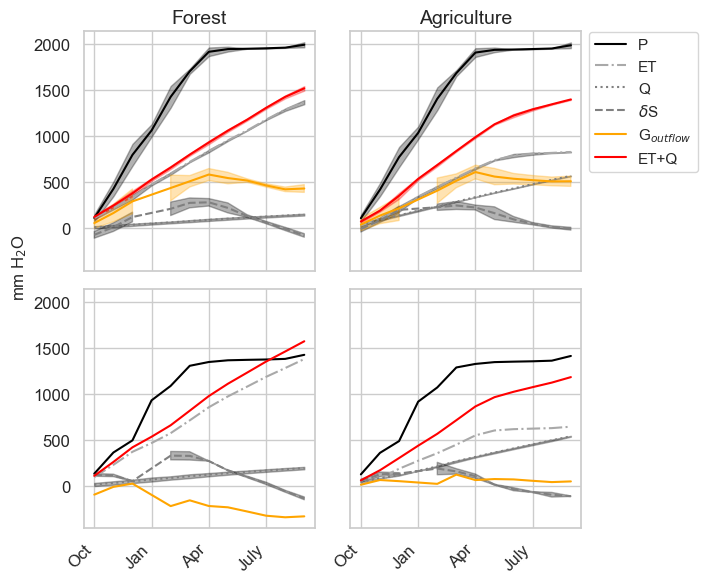

In [17]:
# Create separate plots for each location
# List of locations and precip_regimes
locations = ["Forest", "Agriculture"]
precip_regimes = merged_df['Precip_Regime'].unique()
precip_regime_order=["normal", "drought"]

month_name_mapping = {
            8: 'May',
            9: 'June',
            10: "July",   # May
            11: "Aug",
            12: "Sep",
            1: "Oct",
            2: "Nov",
            3: "Dec",
            4: "Jan",
            5: "Feb",
            6: "Mar",
            7: "Apr"

            }


new_month_names = [month_name_mapping[month] for month in forest_normal_dS['Custom_Month_Order']]





# Create a subplot with two columns
fig, axes = plt.subplots(ncols=len(locations), nrows=len(precip_regime_order), figsize=(7, 6), 
                         sharex=True, sharey=True)
x_values=forest_normal_dS['Custom_Month_Order']
sns.set_theme(style
              ="whitegrid",  rc={"lines.color": "whitesmoke"})
# Iterate over each location
for j, location in enumerate(locations):
    # Filter the DataFrame for the current location
    location_df = merged_df[merged_df['Location'] == location]

    # Iterate over each precip_regime
    for i, regime in enumerate(precip_regime_order):
        # Subset the DataFrame for the current "Precip_Regime"
        regime_df = location_df[location_df['Precip_Regime'] == regime]
        regime_df['Cumulative_Precip_mm'] = regime_df['Precip_mm'].cumsum()
        regime_df['Cumulative_ET_mm'] = regime_df['ET_mm'].cumsum()
        regime_df['Cumulative_Flow mm/month'] = regime_df['Flow_mm/month_mean'].cumsum()
        regime_df['Cumulative_total_change_mm'] = regime_df['total_change_mm_mean'].cumsum()
        regime_df['Cumulative_gbypass_mm'] = regime_df['gbypass_mm'].cumsum()
        regime_df['Cumulative_ETQ_mm'] = regime_df['ET+Q'].cumsum()

    # Plot each variable with different line styles based on "precip_regime"
        sns.set_theme(style="whitegrid")
        sns.lineplot(x='Custom_Month_Order', y='Cumulative_Precip_mm', color="black",  data=regime_df, 
                     ax=axes[i,j], linestyle="-", label="P")
        axes[i,j].fill_between(regime_df['Custom_Month_Order'], regime_df['Cumulative_Precip_mm'] - regime_df['Precip_std'], 
                               regime_df['Cumulative_Precip_mm'] + regime_df['Precip_std'], alpha=0.3, color='black')

        sns.lineplot(x='Custom_Month_Order', y='Cumulative_ET_mm', color='darkgrey',  data=regime_df, 
                     ax=axes[i,j], linestyle="-.", label="ET")
        axes[i,j].fill_between(regime_df['Custom_Month_Order'], regime_df['Cumulative_ET_mm'] - regime_df['ET_std'], 
                               regime_df['Cumulative_ET_mm'] + regime_df['ET_std'], alpha=0.3, color='black')
        
        sns.lineplot(x='Custom_Month_Order', y='Cumulative_Flow mm/month', color='grey', data=regime_df, 
                     ax=axes[i,j], linestyle=":", label="Q")
        axes[i,j].fill_between(regime_df['Custom_Month_Order'], regime_df['Cumulative_Flow mm/month'] - regime_df['Flow_std'], 
                               regime_df['Cumulative_Flow mm/month'] + regime_df['Flow_std'], alpha=0.3, color='black')
        
        sns.lineplot(x='Custom_Month_Order', y='Cumulative_total_change_mm', color='grey',data=regime_df,
                     ax=axes[i,j], linestyle="--", label=r'$\delta$S')
        axes[i,j].fill_between(regime_df['Custom_Month_Order'], regime_df['Cumulative_total_change_mm'] - regime_df['total_change_mm_std'], 
                               regime_df['Cumulative_total_change_mm'] + regime_df['total_change_mm_std'], alpha=0.3, color='black')
        
        sns.lineplot(x='Custom_Month_Order', y='Cumulative_gbypass_mm', color='orange',  data=regime_df,
                     ax=axes[i,j], linestyle="-", label=r"G$_{outflow}$")
        axes[i,j].fill_between(regime_df['Custom_Month_Order'], regime_df['Cumulative_gbypass_mm'] - regime_df['gbypass_mm_std'], 
                               regime_df['Cumulative_gbypass_mm'] + regime_df['gbypass_mm_std'], alpha=0.3, color='orange')
        
        sns.lineplot(x='Custom_Month_Order', y='Cumulative_ETQ_mm', color='red',  data=regime_df,
                     ax=axes[i,j], linestyle="-", label="ET+Q")
        axes[i,j].fill_between(regime_df['Custom_Month_Order'], regime_df['Cumulative_ETQ_mm'] - regime_df['ET+Q_std'], 
                               regime_df['Cumulative_ETQ_mm'] + regime_df['ET+Q_std'], alpha=0.3, color='red')
        labels=[new_month_names[0], new_month_names[3], new_month_names[6], new_month_names[9]]
        axes[0,j].set_title(f'{location.capitalize()}', ha="center", fontsize=14)
        axes[i,j].set_xlabel('', fontsize=12)
        axes[i,0].set_ylabel(f'', fontsize=10,  ha="center")
        step = 3
        axes[i,j].yaxis.set_tick_params(labelsize=12)
        axes[i,j].set_xticks(x_values[::step])
        axes[i,j].set_xticklabels(labels, rotation=45, ha='right', fontsize=12)
        #axes[j,0].annotate(f'{location}', fontsize=14, fontweight="bold", xy=(-0.6, 0.3), ha="center", 
         #                  xycoords="axes fraction", rotation="vertical")
        axes[0,1].legend(bbox_to_anchor=(1, 1.03))
        axes[i,j].legend().set_visible(False)
        #axes[2].legend().set_visible(False)

# Add a shared x-axis label below subplots
fig.text(-0.008, 0.54, 'mm H$_2$O', va='center', rotation='vertical', fontsize=12, fontweight="regular")
#fig.text(-0.04, 0.74, 'Forest', va='center', rotation='vertical', fontsize=14, fontweight="bold")
#fig.text(-0.04, 0.3, 'Agricutlure', va='center', rotation='vertical', fontsize=14, fontweight="bold")

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig("waterbalance_linechart_v3_newet.png", dpi=300, bbox_inches='tight')
plt.show()

In [26]:
# Combine all DataFrames into a single DataFrame
sm_pits = pd.concat(sm_pits, ignore_index=True)
sm_pits["mm H2O"]=sm_pits["cm H2O"]*10

       site                date   total   ano      data  Month Location Depth  \
409940  K04 2012-09-07 18:00:00  2988.3  2012    9/7/12      9   Forest     1   
409941  K04 2012-09-08 00:00:00  2987.2  2012    9/8/12      9   Forest     1   
409944  K04 2012-09-08 18:00:00  2986.3  2012    9/8/12      9   Forest     1   
409945  K04 2012-09-09 00:00:00  2982.2  2012    9/9/12      9   Forest     1   
409946  K04 2012-09-09 06:00:00  2981.2  2012    9/9/12      9   Forest     1   
...     ...                 ...     ...   ...       ...    ...      ...   ...   
410053  K04 2012-10-13 00:00:00  2887.6  2012  10/13/12     10   Forest     1   
410054  K04 2012-10-13 06:00:00  2886.6  2012  10/13/12     10   Forest     1   
410056  K04 2012-10-13 18:00:00  2886.2  2012  10/13/12     10   Forest     1   
410057  K04 2012-10-14 00:00:00  2886.3  2012  10/14/12     10   Forest     1   
410059  K04 2012-10-14 12:00:00  2885.5  2012  10/14/12     10   Forest     1   

        cm H2O  water_year 

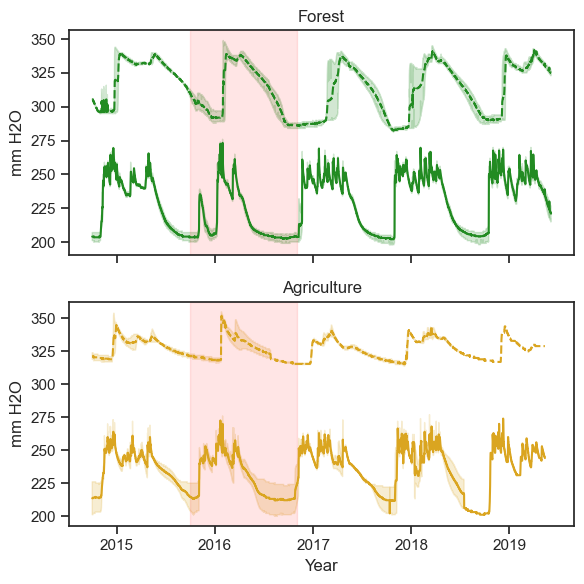

In [30]:

# Filter data for two specific depths
depths_to_plot = ['1',  '8'] #2', '3', '4', '5', '6', '7',
filtered_data = sm_pits[sm_pits['Depth'].isin(depths_to_plot)]
# Specify the depth you're interested in
target_depth = '1'
# Filter the DataFrame for the specified depth
depth_df = filtered_data[filtered_data['Depth'] == target_depth]

# Specify the location and value range
target_location = 'Forest'
min_value = depth_df[depth_df['Location'] == target_location]['mm H2O'].min()
max_value = min_value + 0.5

# Filter the DataFrame for the specified location and value range
filtered_df = depth_df[(depth_df['Location'] == target_location) & (depth_df['mm H2O'] >= min_value) & (depth_df['mm H2O'] <= max_value)]

# Convert the 'Date' column to a datetime object if needed
filtered_df['date'] = pd.to_datetime(filtered_df['date'])

# Calculate the length of time in days for each water year
result = filtered_df.groupby('water_year')['date'].apply(lambda x: (x.max() - x.min()).days + 1).reset_index()

## Plot the soil moisture at 1m and 8m
locations_to_plot = ['Forest', 'Agriculture']
sns.set_style("ticks")
colors=["forestgreen", "goldenrod"]
styles=[ ":", "-"]
style_map=dict(zip(depths_to_plot, styles))
cmap=dict(zip(locations_to_plot, colors))
filtered_data = filtered_data[(filtered_data['water_year'] >= 2015) & (filtered_data['water_year'] <= 2019)]

# Create one plot with two subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 6), sharex=True)

# Iterate over each location and create a subplot
for i, location in enumerate(locations_to_plot):
    # Filter data for the current location
    location_data = filtered_data[filtered_data['Location'] == location]

    # Plot the data for both depths in the current subplot
    sns.lineplot(x='date', y='mm H2O', hue='Location', style='Depth', palette=cmap, 
                 data=location_data, markers=False, ax=axes[i])
    # Start and end dates for the rectangle
    start_date = '2015-10-01'
    end_date = '2016-11-01'

    # Add a semi-transparent rectangle to the background
    axes[i].axvspan(start_date, end_date, color='red', alpha=0.1)
    # Customize the subplot
    axes[i].set_title(f'{location}')
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('mm H2O')
    axes[i].legend().set_visible(False)

# Adjust layout
plt.tight_layout()
plt.savefig("Tanguro_WB_sm_depths_1_8.png", dpi=300)
# Show the plot
plt.show()

In [37]:
depths_to_plot = [0.0,0.3, 0.5, 8, 1, 2, 3, 4, 5, 6, 7]
annual_mean_data_2 = annual_mean_data.groupby(['Depth', 'Location'])['total'].mean().reset_index()
annual_mean_data_2["Depth"]=annual_mean_data_2["Depth"].astype(float)


filtered_data_2 = annual_mean_data_2[annual_mean_data_2['Depth'].isin(depths_to_plot)]

# Function to calculate the sum of measurements with average 0-0.5m as 1m
def calculate_sum_for_site(group):
    # Separate measurements for depths between 0 and 0.5m
    mask = group['Depth'] <= 0.5
    depth_0_to_0_5 = group[mask]
    
    # Calculate average for measurements between 0 and 0.5m
    average_0_to_0_5 = depth_0_to_0_5['total'].mean()

    # Sum measurements for depths greater than 0.5m
    sum_greater_than_0_5 = group[~mask]['total'].sum()

    # Add the average as the 1m value to the total sum
    total_sum = average_0_to_0_5 + sum_greater_than_0_5
    return total_sum

# Group by site and apply the function
result = filtered_data_2.groupby('Location').apply(calculate_sum_for_site).reset_index(name='total_measurement_sum')


In [38]:

## Bootsrapping datasets to see if drought year falls outside normal distribution

time_periods = ['Annual', 'Wet Season', 'Dry Season']
location_types = ['Forest', 'Agriculture']

summary_table=pd.read_csv("/path/to/directory/TWB_datasets/tanguro_summary_means_SD_v3.csv")
summary_table=pd.DataFrame(data=summary_table)
normal_year=summary_table.loc[(summary_table["Regime"]=="normal")]
drought_year=summary_table.loc[(summary_table["Regime"]=="drought")]
#Bootstrap resampling for each time period and location type
num_bootstrap_samples = 1000  # Adjust the number of bootstrap samples as needed
bootstrap_results = {}
mean_std_dict={}
mean_std_list=[]
for time_period in time_periods:
    for location_type in location_types:
        mean_std_dict = {}
        # Extract mean and standard deviation values for the current time period and location type
        subset_means_sd = normal_year[(normal_year['Time'] == time_period) & (normal_year['Landuse'] == location_type)]
        for column in subset_means_sd.columns:
            
            if column.endswith('_mm'):
                key = f"{time_period}_{location_type}_{column[:-3]}"  # Add time_period and location_type to the key
                if key not in mean_std_dict:
                    mean_std_dict[key] = {'mean': [], 'std': []}
                
                mean_std_dict[key]['mean'].append(subset_means_sd[column].iloc[0])
            elif column.endswith('_mm SD'):
                key = f"{time_period}_{location_type}_{column[:-6]}"  # Add time_period and location_type to the key
                mean_std_dict[key]['std'].append(subset_means_sd[column].iloc[0])
        
        mean_std_list.append(mean_std_dict)
        

        
num_bootstrap_samples = 10000  # Adjust the number of bootstrap samples as needed

bootstrap_results = {}

# Step 3: Iterate over each dictionary in the list
for entry in mean_std_list:
    # Iterate over each key in the dictionary (variable name)
    for key, values in entry.items():
        # Extract mean and standard deviation values
        means = values['mean']
        stds = values['std']
        
        # Generate bootstrap samples
        bootstrap_samples = []
        for i in range(num_bootstrap_samples):
            bootstrap_values = np.random.normal(np.mean(means), np.mean(stds), size=len(means))
            bootstrap_samples.append(bootstrap_values)
        
         # Store the bootstrap samples in the results dictionary
        if key not in bootstrap_results:
            bootstrap_results[key] = {'samples': [], 'related_entry': entry}
        bootstrap_results[key]['samples'].append(bootstrap_samples)
drought_mean_dict = {}
## Drought Year
drought_mean_list=[]
for time_period in time_periods:
    for location_type in location_types:
        
        # Extract mean and standard deviation values for the current time period and location type
        subset_means_sd = drought_year[(drought_year['Time'] == time_period) & (drought_year['Landuse'] == location_type)]
        for column in subset_means_sd.columns:
            if column.endswith('_mm'):
                key = f"{time_period}_{location_type}_{column[:-3]}"  # Add time_period and location_type to the key
                if key not in drought_mean_dict:
                    drought_mean_dict[key] = {'mean': []}
                drought_mean_dict[key]['mean'].append(subset_means_sd[column].iloc[0])
            

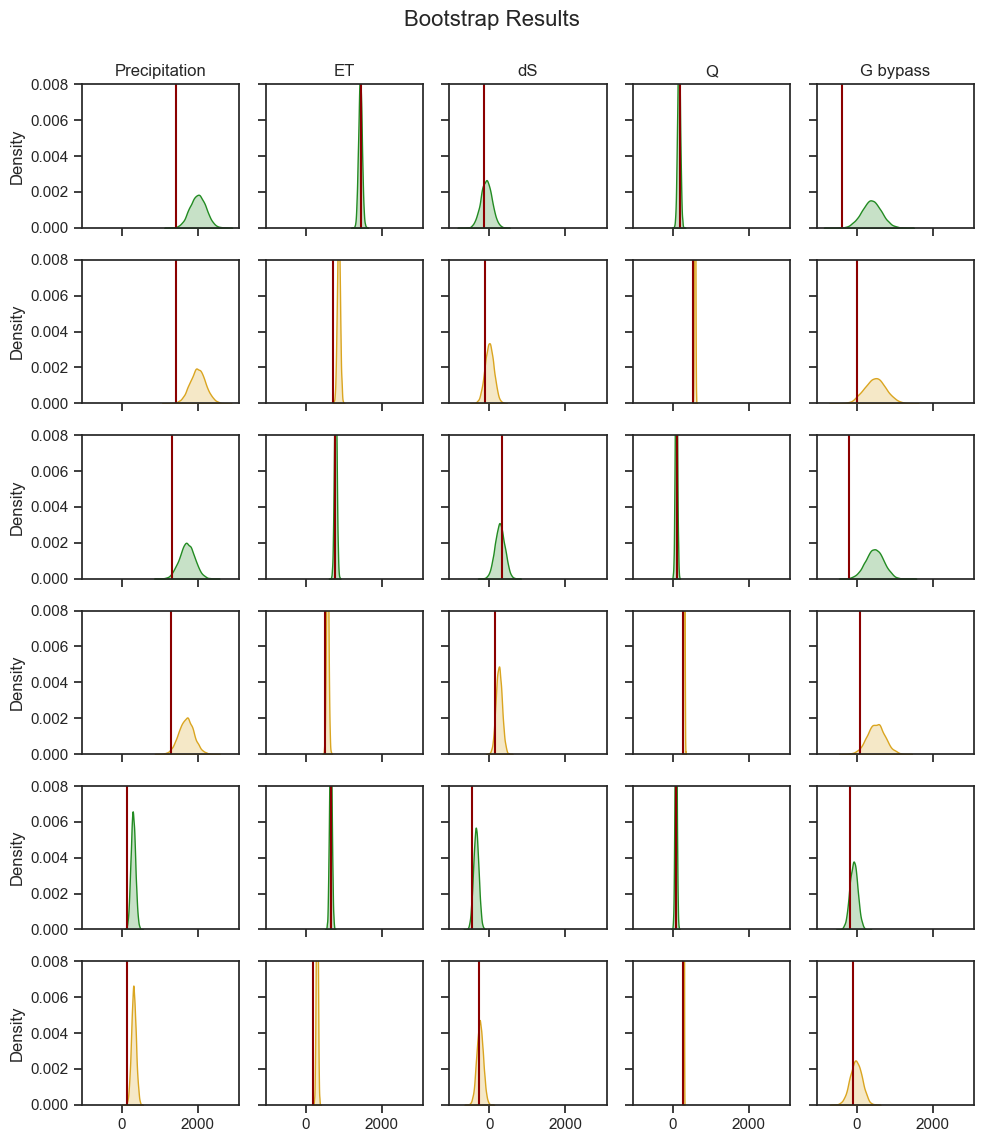

In [39]:
# Plot all bootstrap results and drought year data

keys = {key: data for key, data in bootstrap_results.items()}

# Calculate the number of rows and columns for the subplot grid
num_keys = len(bootstrap_results)
num_rows = 6
num_cols = 5  # Ensure at least two rows

# Step 1: Create a figure and axis objects
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 12),  sharex=True, sharey=True)
key_colors = {}
for key in keys:
    if 'Forest' in key:
        key_colors[key] = 'forestgreen'
    elif 'Agriculture' in key:
        key_colors[key] = 'goldenrod'

# Step 2: Iterate over each key (variable name) in annual_keys
for i, (key, data) in enumerate(bootstrap_results.items()):
    row = i // num_cols
    col = i % num_cols

    # Extract bootstrap samples
    bootstrap_samples = data['samples']
    
    # Flatten the list of bootstrap samples
    flat_samples = np.concatenate(bootstrap_samples)
    # Plot KDE using Seaborn on the corresponding axis with the title set to the dictionary key
    sns.kdeplot(flat_samples.squeeze(), fill=True, ax=axs[row, col], legend=False, color=key_colors[key])  # Disable legend
    if row == 0:  # Only set title for the first row
        axs[row, col].set_title(key.split('_')[-1])  # Set title as the end of the key after the final '_'
    axs[row, col].set_ylim(0,0.008)
    #axs[row, col].set_ylim(0,2000)
    # Add mean value of anomalous year
    
    anomalous_value = drought_mean_dict.get(key, {}).get('mean', [np.nan])[0]  # Get anomalous value corresponding to the key
    if not np.isnan(anomalous_value):
        axs[row, col].axvline(anomalous_value, color='darkred', linestyle='-', label='Drought Year Mean')
    from scipy.stats import wilcoxon

    # Perform Wilcoxon signed-rank test
    statistic, p_value = wilcoxon(flat_samples - anomalous_value)  # Subtract anomalous value from bootstrap samples
    
    #axs[row, col].text(0.5, 0.95, statistic, horizontalalignment='center', verticalalignment='top', transform=axs[row, col].transAxes)
    #axs[row, col].text(0.5, 0.75, p_value, horizontalalignment='center', verticalalignment='top', transform=axs[row, col].transAxes)

    # Print the results
    #print("Wilcoxon statistic:", statistic)
    
# Remove empty subplots
for i in range(num_keys, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axs[row, col])

# Add labels and title
fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate suptitle
fig.suptitle('Bootstrap Results', fontsize=16)
plt.savefig("tanguro_bootstrap_fig.png", dpi=300)
plt.show()

In [40]:
## TANGURO FIELD STATION DATA ##

rain_station=pd.read_csv("/path/to/directory/TWB_datasets/Master_Estacao_Darro_2023.csv")
rain_station=pd.DataFrame(data=rain_station)
selected_years=[ 2009, 2011, 2012, 2013, 2014, 2015,  2017, 2018, 2019]

# Convert the year, month, day columns into a datetime column
rain_station['date'] = pd.to_datetime(rain_station[['Year', 'Month', 'Day']])
# Step 2: Add year, month, and day columns
rain_station['year'] = rain_station['date'].dt.year
rain_station['month'] = rain_station['date'].dt.month
rain_station['day'] = rain_station['date'].dt.day
# For months Oct-Dec, water year is the next calendar year
rain_station['water_year'] = rain_station['year']
rain_station.loc[rain_station['month'] >= 10, 'water_year'] += 1

# Step 3: Calculate the daily average precipitation for each month
# Group by year, month, and day, then calculate the daily average
# Step 2: Calculate daily average precipitation per month
daily_avg = rain_station.groupby(['water_year', 'month', 'day'])['ppt_cor'].sum().reset_index()
temp_df = daily_avg.rename(columns={'water_year': 'year', 'month': 'month', 'day': 'day'})

# Create a temporary date for the first day of each month to get the days in the month
temp_df['first_day'] = pd.to_datetime(temp_df[['year', 'month']].assign(day=1))

# Now calculate the days in the month
daily_avg['days_in_month'] = temp_df['first_day'].dt.days_in_month

# Drop the temporary 'first_day' column
temp_df.drop(columns='first_day', inplace=True)


# Multiply the daily average by the number of days in the month to get the monthly precipitation
monthly_precip = daily_avg.groupby(['water_year', 'month']).apply(
    lambda x: x['ppt_cor'].mean() * x['days_in_month'].max()
).reset_index(name='monthly_precip')

# Step 4: Sum monthly precipitation to get annual precipitation
annual_precip = monthly_precip.groupby('water_year')['monthly_precip'].sum().reset_index()
filtered_years = annual_precip[annual_precip['water_year'].isin(selected_years)]

# Step 5: Calculate the mean and standard deviation of annual precipitation
annual_mean = filtered_years['monthly_precip'].mean()
annual_std = filtered_years['monthly_precip'].std()

# Output the results
#print("Monthly Precipitation:\n", monthly_precip)
print("\nAnnual Precipitation:\n", filtered_years)
print(f"\nMean of Annual Precipitation: {annual_mean}")
print(f"Standard Deviation of Annual Precipitation: {annual_std}")


Annual Precipitation:
     water_year  monthly_precip
5         2009     1763.840983
7         2011     1825.820000
8         2012     2059.360500
9         2013     2028.464000
10        2014     1517.612000
11        2015     1406.502000
13        2017     1550.900000
14        2018     1955.428148
15        2019     1812.582733

Mean of Annual Precipitation: 1768.9455960944406
Standard Deviation of Annual Precipitation: 232.8382309038612


/var/folders/0t/wff4mf392zbg2xjjnxlpkt3c0000gr/T/ipykernel_19508/2107528899.py:3: DtypeWarning: Columns (19,23) have mixed types. Specify dtype option on import or set low_memory=False.
  rain_station=pd.read_csv("/Users/aatwood/Documents/JupyterNotebooks/Tanguro/TWB_datasets/Master_Estacao_Darro_2023.csv")
